# Stability of timestepping schemes

You already saw in CMIII that for some problems if we make the timestep too large in the forward Euler method, we don't get a valid solution. Why is that?

To answer this, we consider the behaviour of the integrator on a linear test problem, the *Dahlquist test equation*:

$$
\dot u = \lambda u \quad \lambda \in \mathbb{C}.
$$

When taking a step of length $h$, this equation has the exact solution

$$
u(h) = u_0 e^{\overbrace{\lambda h}^z} = u_0 e^{\mathfrak{R} z}(\cos \mathfrak{I} z + i\sin\mathfrak{I} z),
$$
where we wrote $\mathbb{C} \ni z = \lambda h$.

This problem is _physically_ stable whenever the real part of $z$ (and hence $\lambda$) is less than zero: $\mathfrak{R} z \le 0$.

### Aside

There is also theory surrounding _nonlinear_ stability, but we will not cover it in this course.

## Stability regions

Let us now consider applying the timestepping schemes we've already encountered to the test equation to see how they behave.

### Explicit Euler

$$
u(h) = \underbrace{(1 + \lambda h)}_{R(z)}u_0.
$$

Repeated application of the scheme results in:

$$
u(mh) = R(z)^m u_0.
$$

This scheme is convergent (producing a bounded $u(mh)$ in the limit $m \to \infty$) only if

$$
|R(z)| \le 1.
$$

### Implicit Euler

Performing a similar calculation we obtain

$$
R(z) = \frac{1}{1 - z}.
$$

### Trapezoidal rule/implicit midpoint

$$
R(z) = \frac{1 + z/2}{1 - z/2}.
$$

### Definitions
The function $R(z)$ is called the *stability function* of the method, the set

$$
S = \{ z \in \mathbb{C} \colon |R(z)| \le 1 \}
$$

is called the *stability domain*.

## Stability plots

Visualising the stability domains, by plotting $|R(z)|$ is an insightful way of comparing methods:

In [ ]:
%matplotlib notebook
from matplotlib import pyplot
import numpy

def plot_stability(x, y, R, label):
    pyplot.figure()
    C = pyplot.contourf(x, y, numpy.abs(R), numpy.linspace(0, 1, 10), cmap=pyplot.cm.coolwarm)
    
    pyplot.colorbar(C, ticks=numpy.linspace(0, 1, 10))
    pyplot.contour(x, y, numpy.abs(Rz), numpy.linspace(0, 1,4), colors='k')
    pyplot.title(label)

<IPython.core.display.Javascript object>


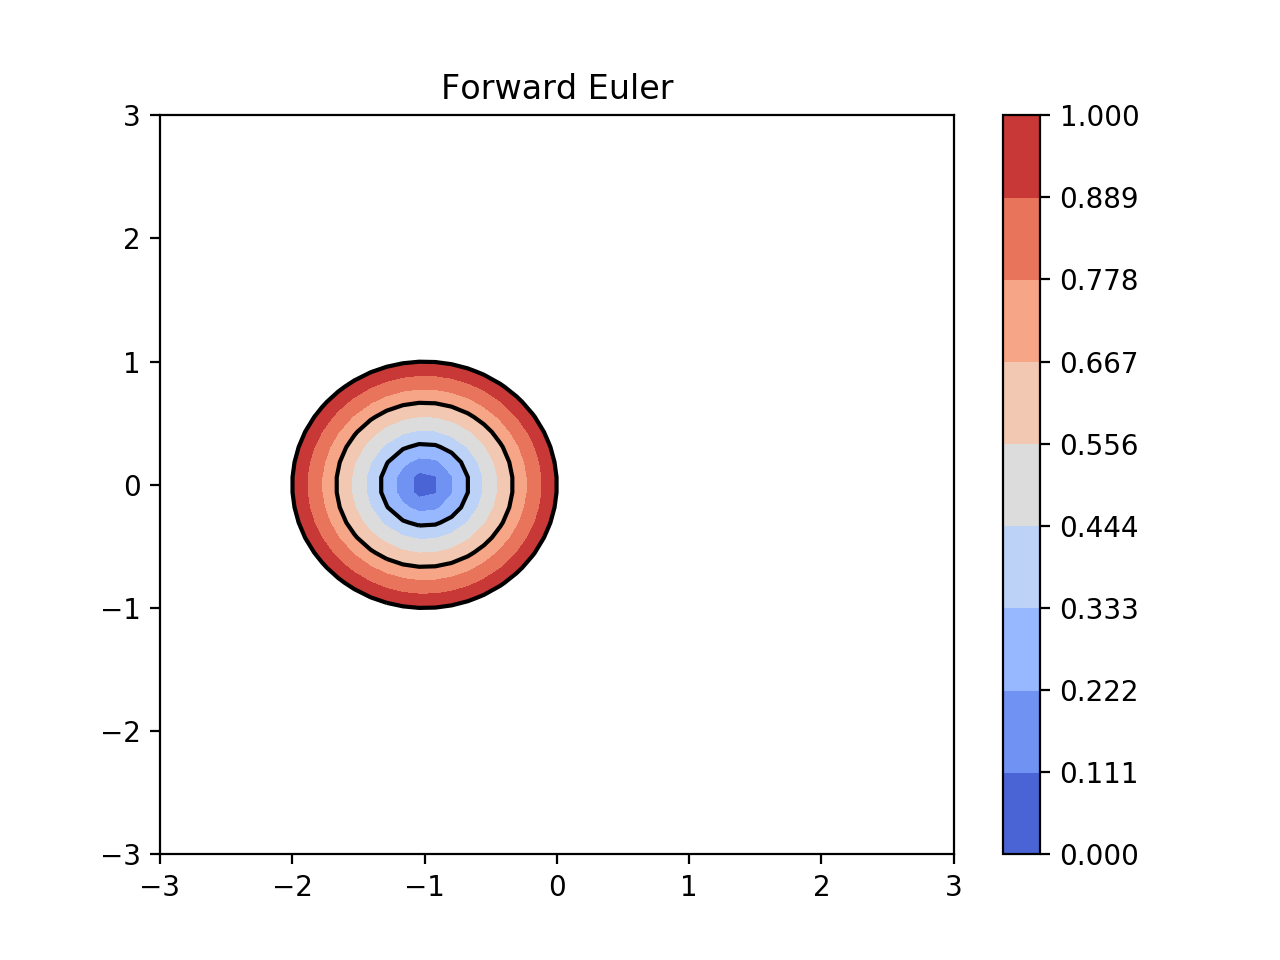

<IPython.core.display.Javascript object>


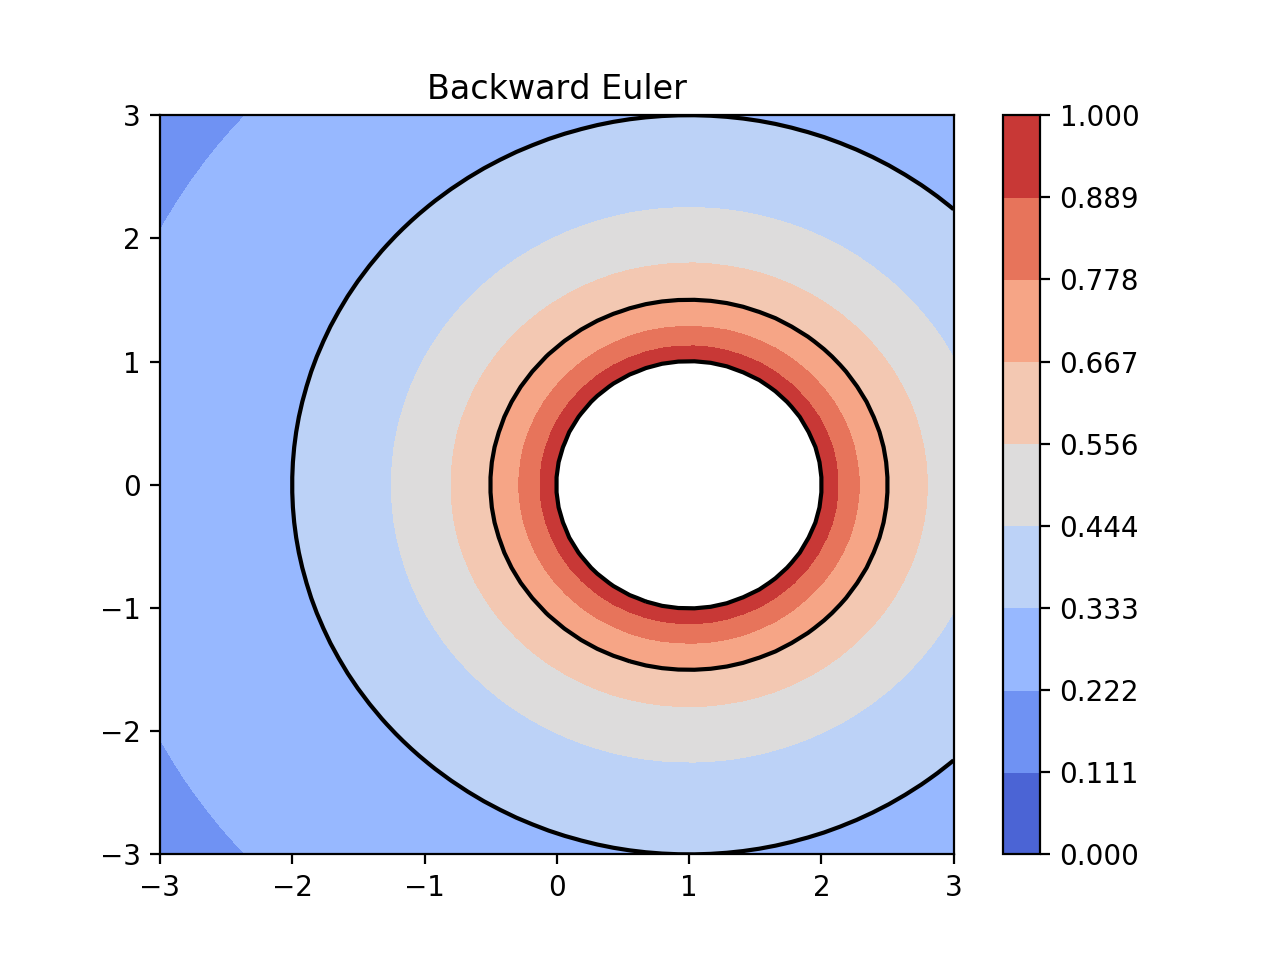

<IPython.core.display.Javascript object>


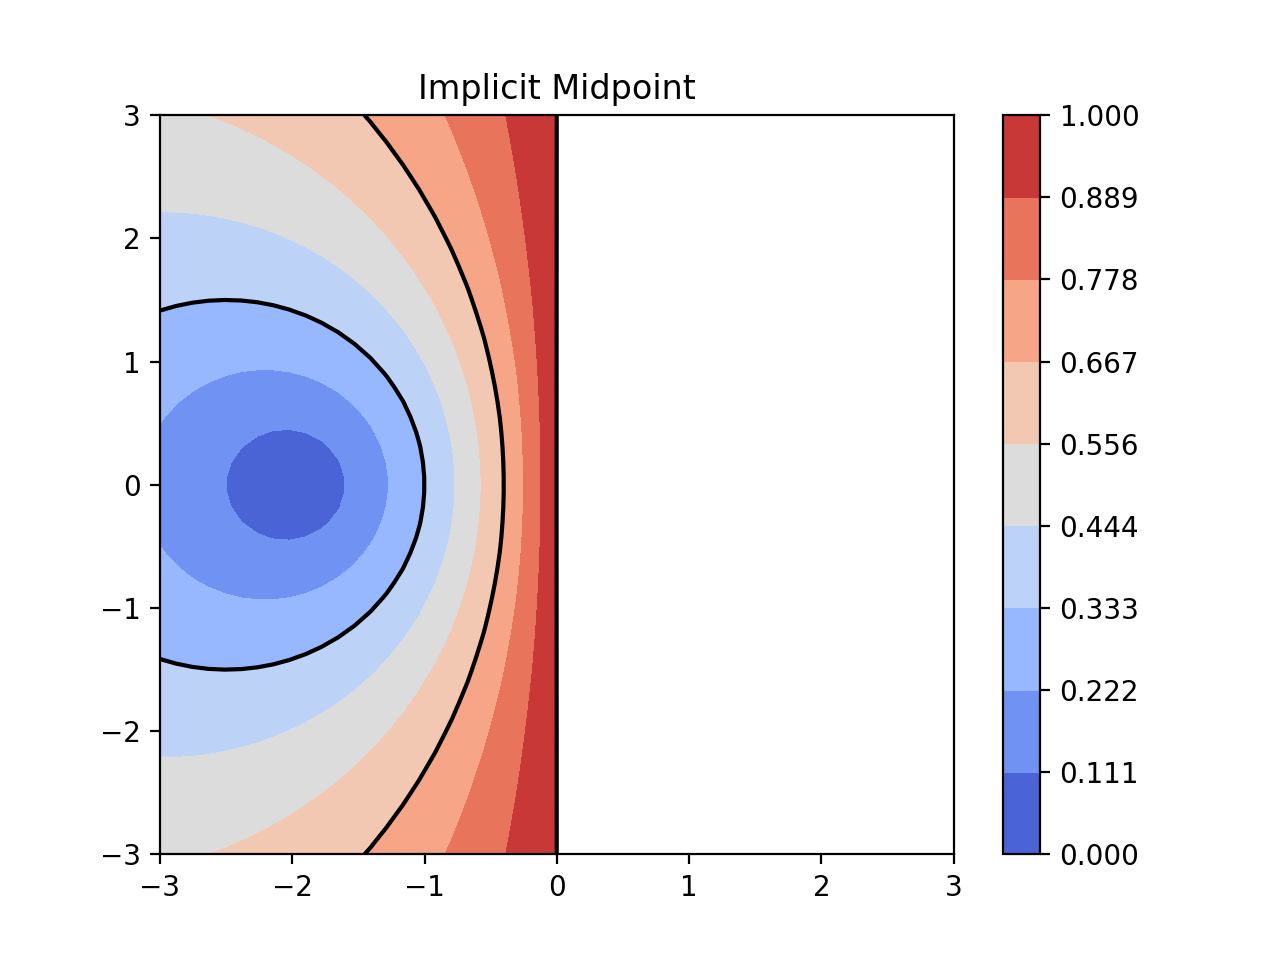

In [5]:
x = numpy.linspace(-3, 3)
x, y = numpy.meshgrid(x, x)
z = x + 1j*y

Rs = [("Forward Euler", 1 + z),
      ("Backward Euler", 1/(1 - z)),
      ("Implicit Midpoint", (1 + z/2)/(1 - z/2))]

for label, Rz in Rs:
    plot_stability(x, y, Rz, label)

### Observations

While the physical problem is stable whenever $\mathfrak{R} \lambda \le 0$, the same is not true of all our methods. The explicit Euler method is only stable in a small region of the left half plane, implicit Euler is stable in the entire left half plane, and more, implicit midpoint is stable in exactly the left half plane.

A question naturally arises? Why would one ever use an explicit method?

## Aims

The goal in developing (and choosing) timestepping methods is to pick one that allows us to take steps as large as possible (i.e. we want the stability region to be large) while maintaining accuracy. Implicit methods allow us to take big timesteps, but, as we saw can be quite inaccurate.

## Definitions

### A-stability

A method is _A-stable_ if the stability domain

$$
S = \{z \in \mathbb{C} \colon |R(z)| \le 1\}
$$

contains the _entire_ left half plane

$$
\operatorname{Re} z \le 0.
$$

This means that we can take arbitrarily large timesteps ($\Delta t \to \infty$) without the method becoming unstable (diverging) for any problem that is physically stable.

### Questions

1. Show that the midpoint method and implicit Euler really do contain the entire left half plane. Hint: multiply through by an appropriate choice of $1$, write $z = a + bi$ and show that $|R(z)| \le 1$ whenever $a \le 0$.